In [25]:
#pip install opencv-python pillow pyheif matplotlib numpy

In [26]:
import cv2
import numpy as np
import pyheif
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path


def show(img, title="", cmap='gray'):
    plt.figure(figsize=(10,6))
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()


# Load Image

In [27]:
def load_image(path):
    path = Path(path)

    if path.suffix.lower() == ".heic":
        heif = pyheif.read(path)
        img = Image.frombytes(
            heif.mode,
            heif.size,
            heif.data,
            "raw",
            heif.mode,
            heif.stride,
        )
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    else:
        img = cv2.imread(str(path))

    if img is None or img.size == 0:
        raise ValueError("Error while loading")

    return img


def resize(img, max_w=1200):
    h, w = img.shape[:2]
    if w <= max_w:
        return img
    scale = max_w / w
    return cv2.resize(img, (int(w*scale), int(h*scale)))


# Preprocessing: Gray → Blur → Adaptive Threshold → Canny

In [28]:
def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    show(gray, "Gray")

    blurred = cv2.GaussianBlur(gray, (13, 13), 0)
    show(blurred, "Blurred")

    binary = cv2.adaptiveThreshold(
        blurred, 
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11, 
        2
    )
    show(binary, "Binary")

    edges = cv2.Canny(binary, 50, 150)
    show(edges, "Canny Edges")

    return gray, binary, edges


# Hough Lines → vertical/horizontal → sort

In [29]:
# stretch a short line all over the picture
def extend_line(x1, y1, x2, y2, W, H):
    if abs(x1 - x2) < abs(y1 - y2):
		# line has very less change in x compared to y -> likely vertical line
        return (x1, 0, x1, H)
    else:
        return (0, y1, W, y1)


def cluster_lines(lines, threshold=12):
    """
    Group lines by there position with a threshold and calcualte the mean
    
    lines: list of lines [(x1,y1,x2,y2), ...]
    threshold: max distance between lines to form a cluster
    """
    if not lines:
        return []

	# i only need one point x1, or y2 because i assume that the lines are straight
	# why check for lower 5? 
 		# -> if x1 ≈ x2 then it is a vertical line. 5 as tolerance as the lines aren't exactly straigth
    coords = []
    for (x1, y1, x2, y2) in lines:
        if abs(x1 - x2) < 5:
            coords.append(x1) #vertical
        else:
            coords.append(y1) #horizontal

	# sort because nearby table lines must appear consecutively
    coords = sorted(coords)
    clusters = [[coords[0]]]

    for c in coords[1:]:
        # coordinate is close to the last one, put it in the same cluster
        if abs(c - clusters[-1][-1]) <= threshold:
            clusters[-1].append(c)
        else:
            #create a new cluster
            clusters.append([c])

    # calculate mean for every cluster
    averaged = [int(sum(cluster) / len(cluster)) for cluster in clusters]
    return averaged



def detect_table_lines(edges, img):
    #image height and width
    H, W = edges.shape

    lines = cv2.HoughLinesP(
        edges,
        1,
        np.pi / 180,
        threshold=115,
        minLineLength=100,
        maxLineGap=10
    )

    vertical = []
    horizontal = []

    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            x1, y1, x2, y2 = extend_line(x1, y1, x2, y2, W, H)
            if abs(x1 - x2) < 5:
                vertical.append((x1, y1, x2, y2))
            elif abs(y1 - y2) < 5:
                horizontal.append((x1, y1, x2, y2))

    dbg = img.copy()
    title = "Detected Table Lines using Clustering"
    # clustering; calculate mean
    xs = cluster_lines(vertical, threshold=15)
    ys = cluster_lines(horizontal, threshold=6)

    for x in xs:
        cv2.line(dbg, (x, 0), (x, H), (0, 0, 255), 2)
    for y in ys:
        cv2.line(dbg, (0, y), (W, y), (255, 0, 0), 2)

    show(dbg, title)

    return xs, ys


# Zellen extrahieren

In [30]:
def extract_cells(xs, ys, header_rows=1, header_cols=0, margin=3):
    """
    creates a list of all table cells based on the xs/ys

    xs, ys: sortiet lines (from detect_table_lines)
    header_rows: number of rows
    header_cols: number of colums
    margin: approximatly margin of the table lines so I can skip scanning them

    return:
      list of tuples with: (habit_idx, day_idx, x, y, w, h)
      
      where:
        - habit_idx = row index inside the data area (0-based)
        - day_idx = column index inside the data area (0-based)
        - x, y = top-left corner of the cell (inside margins)
        - w, h = width/height of the cell (inside margins)
    """
    rows = len(ys) - 1
    cols = len(xs) - 1

    cells = []

    for r in range(header_rows, rows):
        for c in range(header_cols, cols):
            # cell boundaries defined by the table lines
            x = xs[c]
            y = ys[r]
            w = xs[c + 1] - x #the second index (right cell boundary) minus the beginning of the cell
            h = ys[r + 1] - y

			# shrink cell area to avoid scanning on the grid lines
            cell_x = x + margin
            cell_y = y + margin
            cell_w = max(1, w - 2 * margin)
            cell_h = max(1, h - 2 * margin)

			# the area where the habits and days are written - because here are no crosses to be detected :D
            habit_idx = r - header_rows  # 0-basiert
            day_idx = c - header_cols  # 0-basiert

            cells.append((habit_idx, day_idx, cell_x, cell_y, cell_w, cell_h))

    return cells


def draw_cells(img, cells, color=(0, 0, 255), thickness=1, title="Detected Cells"):
    dbg = img.copy()

    for habit_idx, day_idx, x, y, w, h in cells:
        cv2.rectangle(dbg, (x, y), (x + w, y + h), color, thickness)

    show(dbg, title)
    return dbg


# Detect crosses in a cell

In [31]:
DEBUG_CROSS_LIMIT = 20
DEBUG_CROSS_SHOWN = 0


def show_cross_debug(roi, edges, overlay, title=""):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(roi, cmap="gray")
    plt.title("ROI")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Canny")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    plt.imshow(overlay_rgb)
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


def analyze_cell(gray, binary, x, y, w, h, debug=False, tag=""):
    """
    tried different approaches here to detect a cross in the cell
   	1. black pixels ratio
    2. edges ratio based on canny edge detecrtion (count white pixels)
    3. hough and detect lines 
		3.1 first approach was to detect crosses with the property that the lines cross... but didnt work always
		3.2 second approach if there is a line in the cell which is slightly diagonal i assume it's a line of a cross and not a detected table line

    return:
      is_cross (bool), stats, roi_gray, edges, overlay
    """
    global DEBUG_CROSS_SHOWN, DEBUG_CROSS_LIMIT

    roi_gray = gray[y:y+h, x:x+w]
    roi_bin = binary[y:y+h, x:x+w]

    roi_blur = cv2.GaussianBlur(roi_gray, (5, 5), 0)
    edges = cv2.Canny(roi_blur, 50, 150)

    # 1. black pixels count
    black_pixels = np.count_nonzero(roi_bin > 0)
    total_pixels = roi_bin.size
    black_ratio  = black_pixels / total_pixels if total_pixels > 0 else 0.0

    # 2. edges ratio in the image based on the canny edge detection
    edge_pixels = np.count_nonzero(edges > 0)
    edge_ratio  = edge_pixels / total_pixels if total_pixels > 0 else 0.0

	# 3. - but only 3.2 - discarded 3.1
    min_len = int(0.3 * min(w, h))
    lines = cv2.HoughLinesP(
        edges,
        1,
        np.pi / 180,
        threshold=10,
        minLineLength=min_len,
        maxLineGap=2
    )

    diag_count = 0
    line_count = 0
    overlay = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2BGR)

    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            dx = x2 - x1
            dy = y2 - y1
            length = np.hypot(dx, dy)
            # TODO maybe i can ignore this because i check for straight lines and filter out possible table lines that way
            if length < min_len:
                continue

            line_count += 1

            # degree of the line (0° = horizontal, 90° = vertical)
            angle = abs(np.degrees(np.arctan2(dy, dx)))

            # remove straight lines
            # 0–15° and 165–180° could be horizontal lines
            # 75–105° could be vertical lines
            # everything else i assume as diagonal
            is_diagonal = (
                (15 < angle < 75) or   # diagonal to north/upwards
                (105 < angle < 165)    # diagonal to south/downwards
            )

            if is_diagonal:
                diag_count += 1
                cv2.line(overlay, (x1, y1), (x2, y2), (0, 0, 255), 2)

    stats = {
        "diag_count": diag_count,
        "line_count": line_count,
        "black_ratio": black_ratio,
        "edge_ratio": edge_ratio,
    }

    # if at least one diagonal line in that cell, there is a cross
    is_cross = diag_count > 0

    # just for debuggin/analysis
    if debug and DEBUG_CROSS_SHOWN < DEBUG_CROSS_LIMIT:
        DEBUG_CROSS_SHOWN += 1
        title = (
            f"{tag} | cross={is_cross} | "
            f"diag={diag_count}, lines={line_count}, "
            f"black={black_ratio:.2f}, edge={edge_ratio:.2f}"
        )
        # show_cross_debug(roi_gray, edges, overlay, title)

    return is_cross, stats, roi_gray, edges, overlay


# this is just for debbuging - goes through the first row and outputs some stats, images etc
def debug_row(gray, binary, cells, habit_idx=0):
    row_cells = [c for c in cells if c[0] == habit_idx]
    row_cells = sorted(row_cells, key=lambda c: c[1])

    n = len(row_cells)
    if n == 0:
        print("No cell habit_idx", habit_idx)
        return

    fig, axes = plt.subplots(
        2, n,
        figsize=(max(12, n * 0.6), 6),
        squeeze=False
    )

    all_stats = []
    for i, (h_idx, d_idx, x, y, w, h) in enumerate(row_cells):
        is_x, stats, roi, edges, overlay = analyze_cell(
            gray, binary, x, y, w, h,
            debug=False
        )
        all_stats.append((d_idx, stats, is_x))

        ax_top = axes[0, i]
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        ax_top.imshow(edges, cmap="gray")
        ax_top.axis("off")
        
        ax_bottom = axes[1, i]
        ax_bottom.imshow(overlay_rgb, cmap="gray")
        ax_bottom.axis("off")
        ax_bottom.set_title(f"D{d_idx+1}\nX={is_x}", fontsize=7)


    fig.suptitle(f"Habit row {habit_idx+1} - Overlay & Canny ", y=1.02)
    plt.tight_layout()
    plt.show()

    with open('debug_output.txt', 'w') as f:
        f.write("Day | X | lines | black_ratio | edge_ratio\n")
        f.write("------------------------------------------\n")
        for d_idx, s, is_x in all_stats:
            line = (
                f"{d_idx+1:3d} | {1 if is_x else 0:1d} | "
                f"{s['line_count']:5d} | "
                f"{s['black_ratio']:.3f}      | {s['edge_ratio']:.3f}\n"
            )
            f.write(line)
    print(f"Days found {len(all_stats)}")



def detect_crosses(gray, binary, img, cells):
    """
    goes through all cells, detects crosses and shows them in the image

    cells: list of tuples from extract_cells (habit_idx, day_idx, x, y, w, h)
    return:
    	matrix[habit][day] = True/False
     	dbg_img = image with greend marked cross cells
    """
    if not cells:
        return [], img

    max_habit = max(h for h, _, _, _, _, _ in cells) + 1
    max_day = max(d for _, d, _, _, _, _ in cells) + 1

	# basically 2d array with every habits and its day; set per default to false
    matrix = [[False for _ in range(max_day)] for _ in range(max_habit)]
    dbg = img.copy()

    for habit_idx, day_idx, x, y, w, h in cells:
        debug = (DEBUG_CROSS_SHOWN < DEBUG_CROSS_LIMIT)
        tag   = f"H{habit_idx+1} D{day_idx+1}"

        is_x, stats, roi, edges, overlay = analyze_cell(
            gray, binary, x, y, w, h,
            debug=debug,
            tag=tag
        )

        if is_x:
            matrix[habit_idx][day_idx] = True
            cv2.rectangle(
                dbg,
                (x, y),
                (x + w, y + h),
                (0, 255, 0),
                2
            )

    show(dbg, "Detected Crosses (green boxes)")
    return matrix, dbg


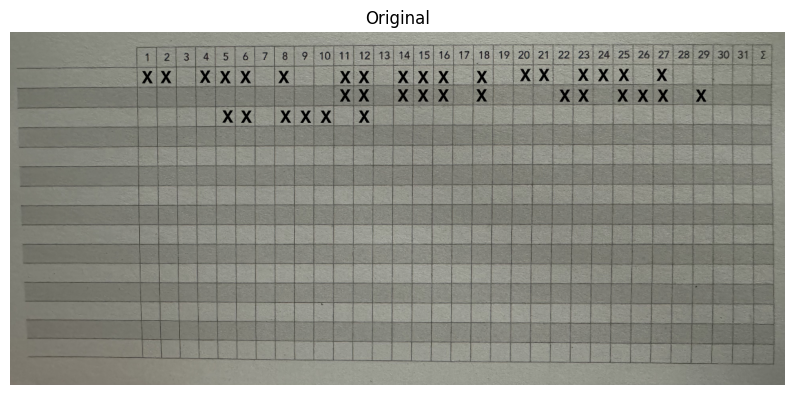

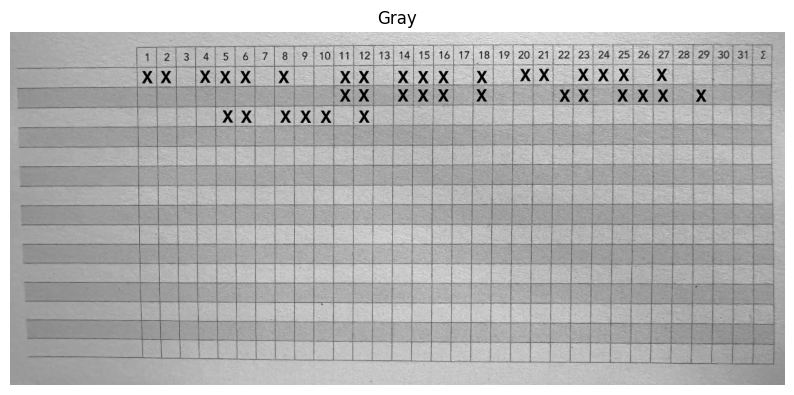

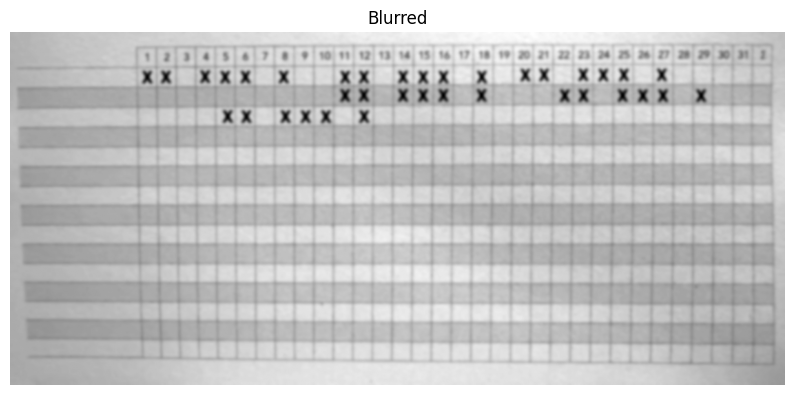

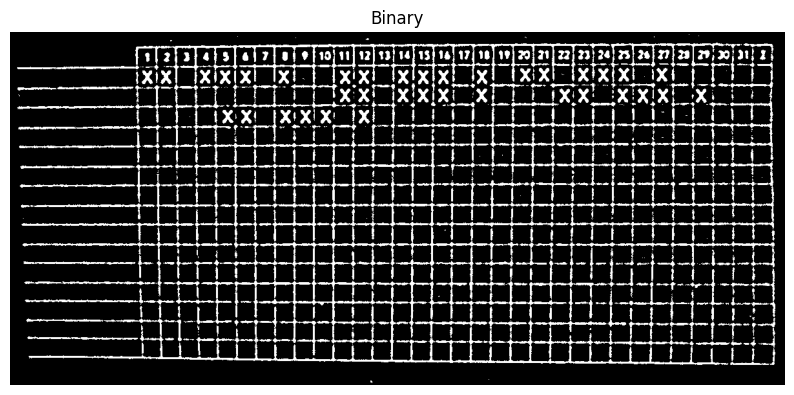

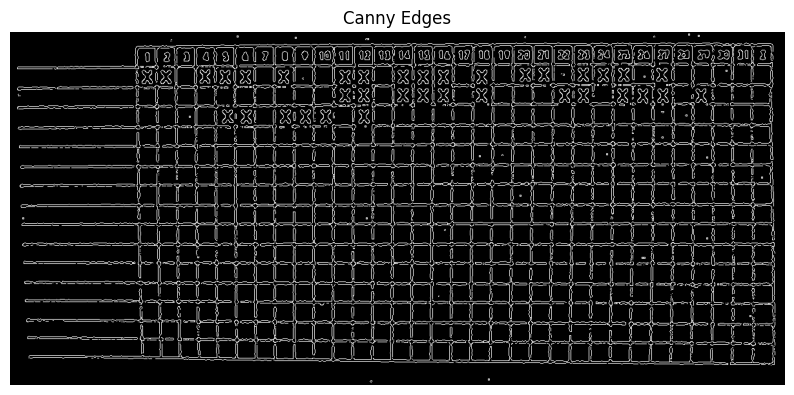

In [32]:
path = "/Users/oguzm1/Documents/02-Projekte/SW Projekte/habit-tracker/uploads/IMG_2935-copy.png"
# path = "/Users/oguzm1/Documents/02-Projekte/SW Projekte/habit-tracker/uploads/IMG_2935.png"
# path = "/Users/oguzm1/Documents/02-Projekte/SW Projekte/habit-tracker/uploads/IMG_2928.png"
# path = "/Users/oguzm1/Documents/02-Projekte/SW Projekte/habit-tracker/uploads/screenshot.png"
# path = "/Users/oguzm1/Documents/02-Projekte/SW Projekte/habit-tracker/uploads/33abbb05-a4fa-4eb4-9253-6930f5bd9a3b.jpg"
# path = "/Users/oguzm1/Documents/02-Projekte/SW Projekte/habit-tracker/uploads/IMG_2925.png"


img = load_image(path)
img = resize(img, 1200)
show(img, "Original")

gray, binary, edges = preprocess(img)

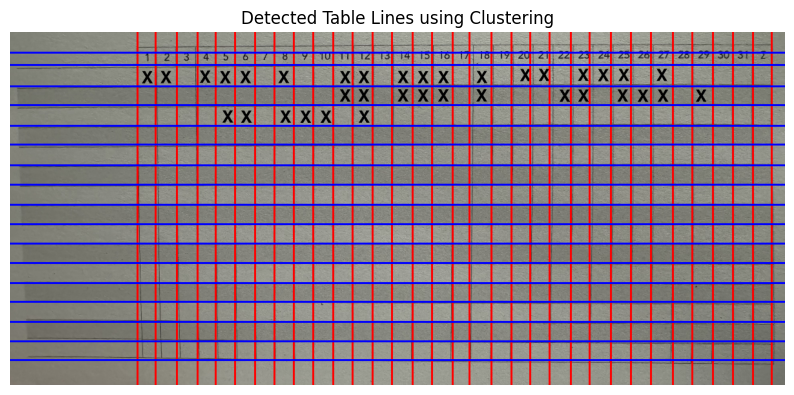

In [33]:
xs, ys = detect_table_lines(edges, img)

Number of cells: 480


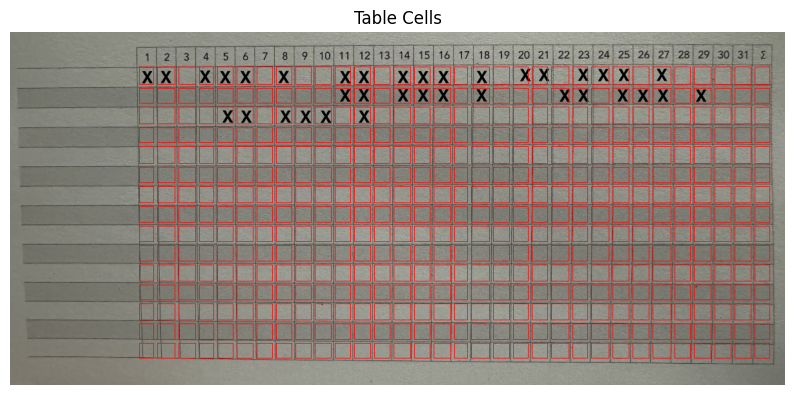

In [34]:
cells = extract_cells(xs, ys, header_rows=1, header_cols=0, margin=3)
print(f"Number of cells: {len(cells)}")

_ = draw_cells(img, cells, color=(0, 0, 255), thickness=1, title="Table Cells")

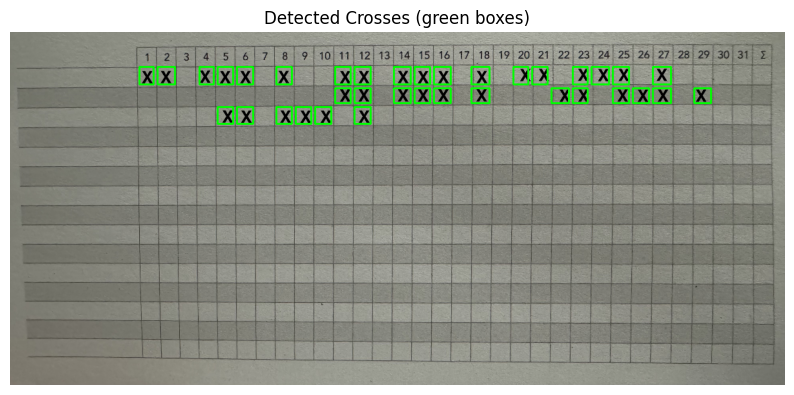

Detected matrix (habit x day):
     1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 1 | X  X  .  X  X  X  .  X  .  .  X  X  .  X  X  X  .  X  .  X  X  .  X  X  X  .  X  .  .  .  .  .  
 2 | .  .  .  .  .  .  .  .  .  .  X  X  .  X  X  X  .  X  .  .  .  X  X  .  X  X  X  .  X  .  .  .  
 3 | .  .  .  .  X  X  .  X  X  X  .  X  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
 4 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
 5 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
 6 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
 7 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
 8 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  
 9 | .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  

In [35]:
matrix, dbg_img = detect_crosses(gray, binary, img, cells)

def print_matrix(matrix):
    print("Detected matrix (habit x day):")
    days = len(matrix[0])

    cell_w = 3
    header = "   " + "".join(f"{d:>{cell_w}}" for d in range(1, days + 1))
    print(header)

    for i, row in enumerate(matrix, 1):
        line = "".join(f"{('X' if x else '.'):{cell_w}}" for x in row)
        print(f"{i:2d} | {line}")

print_matrix(matrix)


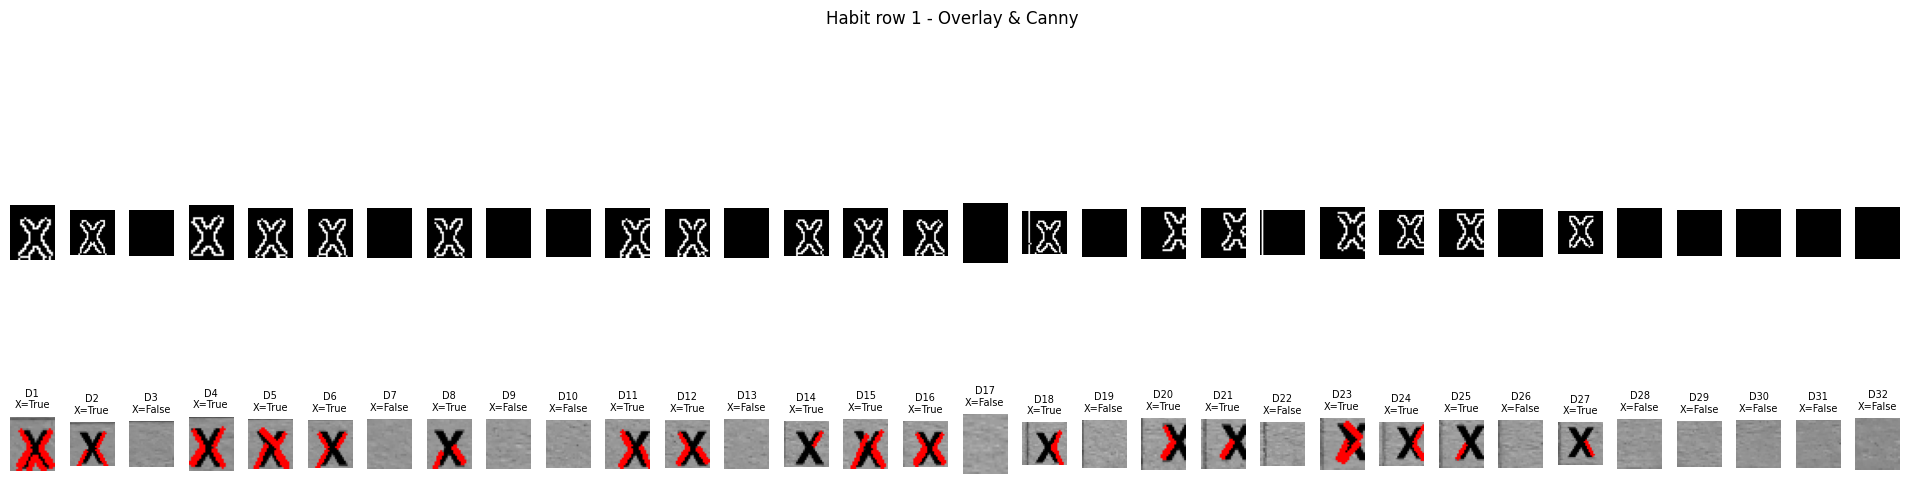

Days found 32


In [36]:
debug_row(gray, binary, cells, habit_idx=0)